In [23]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy
from sklearn.cluster import KMeans
from scipy.optimize import minimize

# ---- ALL HELPER FUNCTIONS GO BELOW -----

# Generates the hanning window 
def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    
    if len(varargin) == 1:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    if len(varargin) == 2: 
        N = varargin[0]
        K = varargin[1]
        Win = Win[:, None, None]                # shape (M, 1, 1)
        Win = np.broadcast_to(Win, (M, N, K))
    return Win

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def frameReshape(frame, numLoopsPerFrame, numRxAntennas):  #
    frameWithChirp = np.reshape(frame, (-1, numLoopsPerFrame, numRxAntennas), order='F')
    return frameWithChirp

# Modified this such that it expects (N x Nrx) size now instead of a 1D array of size N 
def get_RP(data, freq_min, freq_max, mCalData, nfft=2**8, fs=1e6, bg_sub=True, num_rx=4, num_tx=1):
    # data comes reshaped 

    # background subtraction
    if bg_sub:
        for i in range(4):
            data[:,:, i] = data[:, :, i] - data[:,0, i][:,None]
        # data = data - data[..., 0][:, :, None]

    # normalization
    # earlier: for each frame, normalize the data. Now I have to do that for each frame and each antenna 
    # earlier: 
    # for i in range(data.shape[1]):
        # data[:,i] = data[:,i] - data[:,i].mean()
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            data[:,i, j] = data[:,i, j] - data[:,i, j].mean()

    # hanning window used for getting RP 
    Win3D = hanning(data.shape[0], data.shape[1], data.shape[2])        # samples x frame_size x Rx_antennas (radar cube)
    data = data * mCalData
    RP = signal.zoom_fft(np.multiply(data, Win3D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, nfft=2**8):
    # RP : (samples x frame_size) [old]
    # RP : (samples x frame_size x Rx_antennas) [new]
    # WinVel2D = hanning(int(frame_size), nfft)       # want to window on the doppler axis (chirps --> frame_size [256]) 
    # WinVel2D = WinVel2D.transpose()                 # hence the transpose 
    WinVel3D = hanning(RP.shape[1], RP.shape[0], RP.shape[2])   # frame_size x samples x Rx_antennas
    WinVel3D = WinVel3D.transpose(1, 0, 2)                      # samples x frame_size x Rx_antennas

    # getting RD
    RPExt = RP
    for i in range(RPExt.shape[2]):                                # loop over the antennas
        RPExt[:, :, i] = RPExt[:, :, i] - np.mean(RPExt[:, :, i], axis=1)[:,np.newaxis] 

    # np.multipy() --> element-wise multiplication
    RD = np.fft.fft(np.multiply(RPExt, WinVel3D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140, :] = 0 # removing middle doppler noise
    return RD

def get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags):
    c = 2.98e8

    max_idxs = np.zeros(len(f_tags))
    max_corrs = np.zeros(len(f_tags))

    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope

    # Create the face_freq_dict 
    face_freq_dict = {'A': f_tags[0], 'B': f_tags[1], 'C': f_tags[2], 'D': f_tags[3]}

    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
        max_corrs[i] = np.max(correlation)
    
    max_idxs = max_idxs.astype(int)

    # Detect tags above a certain threshold
    corr_thresh = 0                             # NOTE: detection threshold = 0 (for now)
    f_detected = f_tags[max_corrs > corr_thresh]
    faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    ftag_corr_dict = {f_tags[0]: max_corrs[0], f_tags[1]: max_corrs[1], f_tags[2]: max_corrs[2], f_tags[3]: max_corrs[3]}
    clean_dict = {int(k): float(v) for k, v in ftag_corr_dict.items()}

    # kmeans = KMeans(n_clusters=2, n_init=10).fit(max_idxs.reshape(-1, 1))
    # labels = kmeans.labels_
    # majority_label = np.bincount(labels).argmax()
    # majority_cluster = max_idxs[labels == majority_label]
    # print(majority_cluster)
    # target_idx = int(np.mean(max_idxs))
    # target_idx = int(np.mean(majority_cluster))

    target_idx = max_idxs[3]           # setting the range index of D as the target index (NOTE: Need to change this)

    return target_idx, max_idxs, f_detected

def angle_fft(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def angle_fft_windowless(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx
    WinAng3D = np.ones_like(WinAng3D)       # just make it ones 

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

def find_doppler_bins(f_tags, doppler_freqs):
    search_f = np.concatenate((f_tags, -f_tags))
    bins = []

    for f in search_f: 
        err = np.abs(f - doppler_freqs)
        bins.append(np.argmin(err))

    bins_left = bins[len(f_tags):]
    bins_right = bins[:len(f_tags)]

    return bins_left, bins_right

def get_period(Igrid, Fgrid, n_frames):
    freqIndex = []
    for frameIdx in range(n_frames):
        Ipeaks, _ = signal.find_peaks((Igrid[:,frameIdx]))
        Fpeaks, _ = signal.find_peaks((Fgrid[:,frameIdx]))
        # print("peaks: " + str(Ipeaks))
        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Fpeaks)

        freqIndex.extend(per1temp)          # adds all elements of per1temp to freqIndex
        freqIndex.extend(per2temp)          # adds all elements of per2temp to freqIndex

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends (ignores extreme values)
    else:
        period = 0  # Handle case where no peaks are found
    return period                                 # just the mean of periods --> this should be okay 

# ---- need to look at this
def get_period_framewise(Igrid, Qgrid):
    freqIndex = []
    Ipeaks, _ = signal.find_peaks(Igrid)
    Qpeaks, _ = signal.find_peaks(Qgrid)

    per1temp = np.diff(Ipeaks)
    per2temp = np.diff(Qpeaks)

    freqIndex.extend(per1temp)          # adds all elements of per1temp to freqIndex
    freqIndex.extend(per2temp)          # adds all elements of per2temp to freqIndex

    #In the framewise case, there are very few elements in freqIndex, unlike the case where all frames are considered
    # so trimmean doesn't make too much sense 
    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        # period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends (ignores extreme values)
        period = np.mean(freqIndex)
    else:
        period = 0  # Handle case where no peaks are found
    return period                                 # just the mean of periods --> this should be okay 


# Unwrap phases and compute unwrapped distance
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

def get_displacement(Igrid, Qgrid, range_subset_width, n_frames):
    c = 2.98e8
    phi = np.linspace(-np.pi/2, np.pi/2, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    x = np.arange(0, range_subset_width)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(range_subset_width), (n_frames, 1))

    period = get_period(Igrid, Qgrid, n_frames)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((n_frames, len(phi)))
    autoCorr2b = np.zeros((n_frames, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (n_frames, 1))

        # we are taking the sum along axis=1 (range_subset_width dimension) to calculate the correlation
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)           # correlating I with sin
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)           # correlating Q with cos -> why? 
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    return angles 
    
    # return unwrapPi(angles)

def get_displacement_framewise(Igrid, Qgrid, range_subset_width):
    # Igrid and Qgrid are just 1D arrays of the range subset
    c = 2.98e8
    phi = np.linspace(0, np.pi, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    x = np.arange(0, range_subset_width)  # x = 1 : size(magFFTAll, 2)
    triWave = signal.windows.triang(range_subset_width)

    # Have to make this for one frame as well
    period = get_period_framewise(Igrid, Qgrid)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((len(phi), 1))
    autoCorr2b = np.zeros((len(phi), 1))
    for phiIdx, phiVal in enumerate(phi):
        sinW = np.abs(np.sin(x * np.pi / period + phiVal))                      # just repeats across frames
        cosW = np.abs(np.cos(x * np.pi / period + phiVal))

        # we are taking the sum along axis=1 (range_subset_width dimension) to calculate the correlation
        autoCorr2a[phiIdx] = np.sum(normalize(Igrid) * sinW * triWave)           # correlating I with sin
        autoCorr2b[phiIdx] = np.sum(normalize(Qgrid) * cosW * triWave)           # correlating Q with cos -> why? 
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    print(f"autocorr.shape = {autocorr.shape}")
    I = np.argmax(autocorr)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles)
    print(f"angles.shape = {angles.shape}") 
    return angles 
    # return unwrapPi(angles)

# Face-wise Phase extraction 
def get_phases(filename, n_frames, f_tags = np.array([156, 250, 313, 625]), sides=[0,1,2,3]):
    # data = pickle.load(open('/nas-data/soham/drone-landing/test_rotate-24GHz.pickle', 'rb'))
    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']
    print(f"data_raw.shape = {data_raw.shape}")

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    # f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))

    # n_frames = 160 

    # range_subset_width = 80 
    range_subset_width = 80
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    Igrid = np.zeros((4, range_subset_width, n_frames))
    Qgrid = np.zeros((4, range_subset_width, n_frames))
    Pgrid = np.zeros((4, range_subset_width, n_frames))
    dopgrid = np.zeros((nfft, num_rx))

    # side1 = 1
    # side2 = 3
    # side3 = 2
    # side4 = 0        

    side1 = sides[0]
    side2 = sides[1]
    side3 = sides[2]
    side4 = sides[3]

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    range_idxs = []
    range_idxs_A = []
    range_idxs_B = []
    range_idxs_C = []
    range_idxs_D = []
    # Do all this for a single frame
    for frame_no in range(0, n_frames):
        # print(f"Processing frame {frame_no}...")
        frame = data_raw[:, frame_no ,:]
        data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
        RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
        RD = get_RD(RP)        # 256 x 256 x 4 

        range_idx, max_idxs = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)
        # prevent range index spikes 
        if frame_no > 0 and np.abs(range_idx - range_idxs[-1]) > 3: 
            range_idx = range_idxs[-1]              # keep using the same range index 
        range_idxs.append(range_idx)
        range_idxs_A.append(max_idxs[0])
        range_idxs_B.append(max_idxs[1])
        range_idxs_C.append(max_idxs[2])
        range_idxs_D.append(max_idxs[3])
        # print(range_idx)
        
        # take for only one antenna for now 
        RD = RD[:, :, antenna_pick]

        for i in range(len(f_tags)):
            # Take the range subset for all angles 
            RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]     
            
            I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
            Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

            # Take the phase across the range subset 
            phase = np.atan(I_tag/Q_tag) 

            Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
            Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
            Pgrid[i][:, frame_no] = normalize(np.abs(phase))

    # phase values for each frequency
    phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
    phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
    phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
    phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

    return phaseA, phaseB, phaseC, phaseD, range_idxs, range_idxs_A, range_idxs_B, range_idxs_C, range_idxs_D
    # return range_idxs

In [25]:
def get_xyz(filename, n_frames, f_tags = np.array([156, 250, 313, 625]), sides=[0,1,2,3]):
    
    # Define constants
    c= 2.8e8
    f = 24.15e9
    lam = c/f
    a = np.array((0.0,   0.045, -0.02))    # face A
    b = np.array((-0.04, 0.0,   -0.02 ))   # face B
    x1 = b[0]
    y2 = a[1]
    z1 = b[2]
    z2  = a[2]

    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']
    print(f"data_raw.shape = {data_raw.shape}")

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    # f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calculate range step
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))

    # n_frames = 160 

    # range_subset_width = 80 
    range_subset_width = 80
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    Igrid = np.zeros((4, range_subset_width, n_frames))
    Qgrid = np.zeros((4, range_subset_width, n_frames))
    Pgrid = np.zeros((4, range_subset_width, n_frames))
    # dopgrid = np.zeros((nfft, num_rx))

    # side1 = 1
    # side2 = 3
    # side3 = 2
    # side4 = 0        

    side1 = sides[0]
    side2 = sides[1]
    side3 = sides[2]
    side4 = sides[3]

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    range_idxs = []
    range_idxs_A = []
    range_idxs_B = []
    range_idxs_C = []
    range_idxs_D = []

    xr_array = []
    yr_array = []
    zr_array = []

    phaseA_array = []
    phaseB_array = []
    phaseC_array = []
    phaseD_array = []

    # Setup phaseAD and phaseBD shifts here
    # NOTE: Have to change this to have everything
    phase_shift_AD = 0 
    phase_shift_BD = 0 

    # Do all this for a single frame 
    for frame_no in range(0, n_frames):

        Igrid = np.zeros((4, range_subset_width))
        Qgrid = np.zeros((4, range_subset_width))
        Pgrid = np.zeros((4, range_subset_width))

        # print(f"Processing frame {frame_no}...")
        frame = data_raw[:, frame_no ,:]
        data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
        RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
        RD = get_RD(RP)        # 256 x 256 x 4 

        range_idx, max_idxs, f_detected = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

        # prevent range index spikes 
        if frame_no > 0 and np.abs(range_idx - range_idxs[-1]) > 3: 
            range_idx = range_idxs[-1]              # keep using the same range index 
        range_idxs.append(range_idx)
        range_idxs_A.append(max_idxs[0])
        range_idxs_B.append(max_idxs[1])
        range_idxs_C.append(max_idxs[2])
        range_idxs_D.append(max_idxs[3])
        
        # take for only one antenna for now 
        RD = RD[:, :, antenna_pick]

        for i in range(len(f_detected)):
            # Take the range subset for all angles 
            RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]     
            
            I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
            Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

            # Take the phase across the range subset 
            phase = np.atan(I_tag/Q_tag) 

            Igrid[i,:] = normalize(np.abs((I_tag)))
            Qgrid[i,:] = normalize(np.abs((Q_tag)))
            Pgrid[i,:] = normalize(np.abs(phase))

        # NOTE: Have to change this to figure out what to do with a face's phase when the 
        #       face goes out of detection and then comes back up again

        # Wrapped phase values for each frequency
        phaseA = get_displacement_framewise(Igrid[0, :], Qgrid[0, :], range_subset_width)          # face A
        phaseB = get_displacement_framewise(Igrid[1, :], Qgrid[1, :], range_subset_width)          # face B 
        phaseC = get_displacement_framewise(Igrid[2, :], Qgrid[2, :], range_subset_width)          # face C
        phaseD = get_displacement_framewise(Igrid[3, :], Qgrid[3, :], range_subset_width)          # face D

        # Store the values in the phase array and send it for unwrapping 
        phaseA_array.append(phaseA)
        phaseB_array.append(phaseB)
        phaseC_array.append(phaseC)
        phaseD_array.append(phaseD)

        # Unwrapping
        if frame_no>0:
            phaseA_array = list(np.unwrap(phaseA_array))
            phaseB_array = list(np.unwrap(phaseB_array))
            phaseC_array = list(np.unwrap(phaseC_array))
            phaseD_array = list(np.unwrap(phaseD_array))

        # NOTE: Need to write code here which only takes into consideration which faces are being seen 
        # Assuming that face A, B and D are being seen (for now)
        phaseAD = phaseA_array[-1] - phaseD_array[-1]
        phaseBD = phaseB_array[-1] - phaseD_array[-1]

        # If its the first frame, then store the shift value 
        # NOTE: Need to fix this to store the shift of the first few values instead of the very first one 
        # as the very first ones might be very noisy  
        if frame_no==0:
            # Store phase values as anchors 
            phaseAD_anchor = phaseAD
            phaseBD_anchor = phaseBD

            # Calculate the ideal unwrapped phase values 
            d_hat = np.array((0, 0, 1))
            dr_a = d_hat @ a
            dr_b = d_hat @ b
            dphi_a = (4*np.pi/lam) * dr_a
            dphi_b = (4*np.pi/lam) * dr_b

            # Calculate phase shifts
            phase_shift_AD = dphi_a - phaseAD_anchor  
            phase_shift_BD = dphi_b - phaseBD_anchor
        
        # Shift the phase values
        phaseAD = phaseAD + phase_shift_AD
        phaseBD = phaseBD + phase_shift_BD

        # Reshape phaseAD and phaseBD 
        print(phaseAD.shape)
        print(phaseBD.shape)

        # ---  Perform the optimization
        # Define delta r's 
        dr1 = -(lam/(4*np.pi))*phaseBD
        dr2 = -(lam/(4*np.pi))*phaseAD
        
        # Define cost function 
        def f(args):
            theta, phi = args
            f1 = dr1 - (x1*np.cos(theta)*np.sin(phi) - z1*np.cos(phi))
            f2 = dr2 - (y2*np.sin(theta)*np.sin(phi) - z1*np.cos(phi))
            return f1**2 + f2**2
        
        # Set initial guess
        x0 = [np.pi/2, np.pi/2]

        # Perform minimization
        res = minimize(f, x0, method='Nelder-Mead')  # or Nelder-Mead if non-smooth
        theta = res.x[0]
        phi = res.x[1]

        # Calculate x, y, z
        r = range_steps[range_idx]
        xr = r*np.cos(theta)*np.sin(phi)
        yr = r*np.sin(theta)*np.sin(phi)
        zr = r*np.abs(np.cos(phi))

        xr_array.append(xr)
        yr_array.append(yr)
        zr_array.append(zr)
    
    return xr_array, yr_array, zr_array, phaseA_array, phaseB_array, phaseC_array, phaseD_array



In [26]:
xr, yr, zr, phaseA, phaseB, phaseC, phaseD = get_xyz(filename="/nas-data/soham/drone-landing/vertical_move_1000l_-165_to_210mm-24GHz.pickle", n_frames=653)

data_raw.shape = (32768, 653, 4)
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.sha

/tmp/ipykernel_539013/4217720783.py:294: RuntimeWarning: divide by zero encountered in divide
  sinW = np.abs(np.sin(x * np.pi / period + phiVal))                      # just repeats across frames
/tmp/ipykernel_539013/4217720783.py:294: RuntimeWarning: invalid value encountered in divide
  sinW = np.abs(np.sin(x * np.pi / period + phiVal))                      # just repeats across frames
/tmp/ipykernel_539013/4217720783.py:294: RuntimeWarning: invalid value encountered in sin
  sinW = np.abs(np.sin(x * np.pi / period + phiVal))                      # just repeats across frames
/tmp/ipykernel_539013/4217720783.py:295: RuntimeWarning: divide by zero encountered in divide
  cosW = np.abs(np.cos(x * np.pi / period + phiVal))
/tmp/ipykernel_539013/4217720783.py:295: RuntimeWarning: invalid value encountered in divide
  cosW = np.abs(np.cos(x * np.pi / period + phiVal))
/tmp/ipykernel_539013/4217720783.py:295: RuntimeWarning: invalid value encountered in cos
  cosW = np.abs(np.cos(x * np.p

autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
()
()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1)
angles.shape = ()
autocorr.shape = (4001, 1

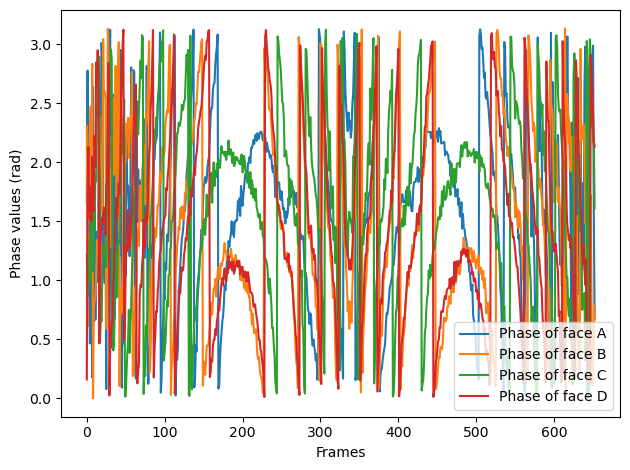

In [27]:
plt.plot(phaseA, label="Phase of face A")
plt.plot(phaseB, label="Phase of face B")
plt.plot(phaseC, label="Phase of face C")
plt.plot(phaseD, label="Phase of face D")
plt.legend()
plt.xlabel("Frames")
plt.ylabel("Phase values (rad)")
plt.tight_layout()

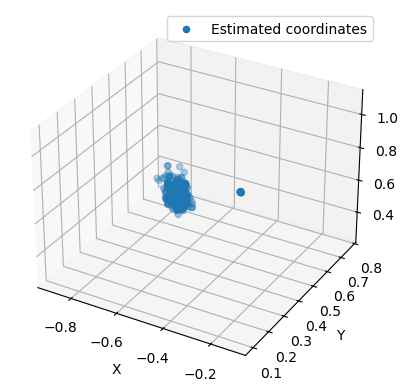

In [29]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Line plot in 3D
ax.scatter3D(xr, yr, zr, label="Estimated coordinates")     # or ax.plot(x, y, z)
# ax.scatter3D(d[:, 0][N1:N2], d[:, 1][N1:N2], d[:, 2][N1:N2], label="Ground Truth")
# If you want points instead of a line:
# ax.scatter3D(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_zlim([0, 2])
# ax.set_xlim([0, 0.75])

ax.legend()

plt.show()